# Reinforcement Learning with S&P 500 Data

In [98]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv, StocksEnv, StocksEnv, Actions, Positions 

#rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3

In [99]:
database = sqlite3.connect("MSFT_all_inds.sqlite")
df = pd.read_sql_query("SELECT * FROM prices", database)

df

,id,name,date,high,low,close,ema10,ema20,ema50,high_perc,...,price_chg,massi,mfi,adx,dmp,dmn,rsi,slowd,slowk,target
0,1,CMPS,1986-03-13 00:00:00,0.063838,0.055654,0.061109,NaN,NaN,NaN,-4.465038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,CMPS,1986-03-14 00:00:00,0.064384,0.061109,0.063292,NaN,NaN,NaN,-1.725027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,CMPS,1986-03-17 00:00:00,0.064929,0.063292,0.064384,NaN,NaN,NaN,-0.847400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,CMPS,1986-03-18 00:00:00,0.064929,0.062201,0.062746,NaN,NaN,NaN,-3.479052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,CMPS,1986-03-19 00:00:00,0.063292,0.061109,0.061655,NaN,NaN,NaN,-2.654705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9165,9166,CMPS,2022-07-25 00:00:00,261.500000,256.809998,258.829987,259.772761,259.767939,263.551652,-1.031570,...,-1.190879,24.777987,50.316884,13.957664,19.168164,24.438113,48.583755,69.530917,66.623372,1.0
9166,9167,CMPS,2022-07-26 00:00:00,259.880005,249.570007,251.899994,258.341349,259.018611,263.094724,-3.167928,...,-4.273273,24.892568,41.376154,14.786766,17.230518,29.066357,42.475329,62.057819,47.967078,0.0
9167,9168,CMPS,2022-07-27 00:00:00,270.049988,258.850006,268.739990,260.232011,259.944457,263.316107,-0.487459,...,-0.375909,25.106050,45.353526,13.868004,23.470872,24.391800,56.716717,57.763220,58.699210,0.0
9168,9169,CMPS,2022-07-28 00:00:00,277.839996,267.869995,276.410004,263.173464,261.512604,263.829593,-0.517345,...,0.535265,25.305304,52.597265,13.718696,28.219661,22.272812,61.403596,59.540136,71.954118,0.0


In [100]:
df['Date'] = pd.to_datetime(df['date'])
df.drop(['date'], axis=1, inplace=True)
df.dtypes

id                    int64
name                 object
high                float64
low                 float64
close               float64
ema10               float64
ema20               float64
ema50               float64
high_perc           float64
low_perc            float64
price_chg           float64
massi               float64
mfi                 float64
adx                 float64
dmp                 float64
dmn                 float64
rsi                 float64
slowd               float64
slowk               float64
target              float64
Date         datetime64[ns]
dtype: object

In [101]:
df.columns

Index(['id', 'name', 'high', 'low', 'close', 'ema10', 'ema20', 'ema50',
       'high_perc', 'low_perc', 'price_chg', 'massi', 'mfi', 'adx', 'dmp',
       'dmn', 'rsi', 'slowd', 'slowk', 'target', 'Date'],
      dtype='object')

In [102]:
df.drop([ "id", "name", "target" ], axis=1, inplace=True)
df.dropna(inplace=True)
df.set_index('Date', inplace=True)
df['Close'] = df['close']
df.drop([ "close" ], axis=1, inplace=True)
df

,high,low,ema10,ema20,ema50,high_perc,low_perc,price_chg,massi,mfi,adx,dmp,dmn,rsi,slowd,slowk,Close
Date,,,,,,,,,,,,,,,,,
1986-05-22,0.068203,0.067657,0.068892,0.068532,0.065032,-0.806399,0.000000,0.781155,24.001111,32.768218,20.706028,28.929454,22.434311,48.589848,14.357438,4.761894,0.067657
1986-05-23,0.068748,0.067657,0.068667,0.068448,0.065135,-1.612799,0.000000,-0.787305,23.820025,35.219979,20.403548,29.943786,21.354329,48.589848,5.952386,0.000000,0.067657
1986-05-27,0.069839,0.067657,0.068880,0.068581,0.065320,0.000000,3.124803,0.781155,23.758560,36.890670,20.706106,31.827962,19.348198,58.124555,7.142837,16.666616,0.069839
1986-05-28,0.072022,0.069839,0.069451,0.068909,0.065583,0.000000,3.030118,0.775164,23.866544,44.009165,21.928360,38.091368,17.570554,65.095960,22.222173,49.999901,0.072022
1986-05-29,0.074750,0.071476,0.070216,0.069361,0.065899,-1.481381,2.963613,-0.781219,24.185698,55.775650,23.918047,43.939597,15.299446,69.234405,48.290668,78.205488,0.073659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-22,265.329987,259.070007,259.982267,259.866671,263.744373,-1.908896,0.495459,-0.276466,24.754640,56.790376,14.101692,20.124086,23.253709,50.059645,65.695862,71.583007,260.359985
2022-07-25,261.500000,256.809998,259.772761,259.767939,263.551652,-1.031570,0.780431,-1.190879,24.777987,50.316884,13.957664,19.168164,24.438113,48.583755,69.530917,66.623372,258.829987
2022-07-26,259.880005,249.570007,258.341349,259.018611,263.094724,-3.167928,0.924965,-4.273273,24.892568,41.376154,14.786766,17.230518,29.066357,42.475329,62.057819,47.967078,251.899994


In [103]:
#df = df.iloc[::-1]
#df

In [104]:
def make_lags(name, feature, lags):
    return pd.concat(
    {
        f'{name}_lag_{i}': feature.shift(i)
        for i in range(1, lags + 1)
    },
    axis = 1)

df = df.join(make_lags("price", df.Close, lags=5))
df = df.join(make_lags("high", df.high, lags=5))
df = df.join(make_lags("low", df.low, lags=5))
df = df.join(make_lags("pricechg", df.price_chg, lags=5))
df = df.join(make_lags("highperc", df.high_perc, lags=5))
df = df.join(make_lags("lowperc", df.low_perc, lags=5))
df = df.join(make_lags("massi", df.massi, lags=5))
df = df.join(make_lags("mfi", df.mfi, lags=5))
#df = df.join(make_lags("ema10", df.ema20, lags=5))
#df = df.join(make_lags("ema20", df.ema20, lags=5))
#df = df.join(make_lags("ema50", df.ema50, lags=5))
df = df.join(make_lags("adx", df.adx, lags=5))
df = df.join(make_lags("dmp", df.dmp, lags=5))
df = df.join(make_lags("dmn", df.dmn, lags=5))
df = df.join(make_lags("slowk", df.slowk, lags=5))
df = df.join(make_lags("slowd", df.slowd, lags=5))
df = df.join(make_lags("rsi", df.rsi, lags=5))

#df["target"] = df["ema10"].shift(-5)

df.dropna(inplace=True)

X = df
#y = df["target"]



In [105]:
X

,high,low,ema10,ema20,ema50,high_perc,low_perc,price_chg,massi,mfi,...,slowd_lag_1,slowd_lag_2,slowd_lag_3,slowd_lag_4,slowd_lag_5,rsi_lag_1,rsi_lag_2,rsi_lag_3,rsi_lag_4,rsi_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
1986-05-30,0.077478,0.074205,0.071338,0.070030,0.066311,-1.428478,2.856955,0.000000,24.084537,60.188215,...,48.290668,22.222173,7.142837,5.952386,14.357438,69.234405,65.095960,58.124555,48.589848,48.589848
1986-06-02,0.076387,0.074205,0.071860,0.070428,0.066620,-2.940977,0.000000,0.775164,23.766374,53.286987,...,73.124713,48.290668,22.222173,7.142837,5.952386,74.631167,69.234405,65.095960,58.124555,48.589848
1986-06-03,0.074205,0.073113,0.072286,0.070787,0.066918,0.000000,1.471334,-1.574675,23.568591,51.412587,...,83.144199,73.124713,48.290668,22.222173,7.142837,64.833119,74.631167,69.234405,65.095960,58.124555
1986-06-04,0.074750,0.073113,0.072536,0.071061,0.067182,-1.481381,0.741542,-0.793640,23.422232,52.331199,...,81.767592,83.144199,73.124713,48.290668,22.222173,64.833119,64.833119,74.631167,69.234405,65.095960
1986-06-05,0.074750,0.073113,0.072938,0.071412,0.067479,0.000000,2.190473,-1.612804,23.249910,54.353633,...,72.983656,81.767592,83.144199,73.124713,48.290668,62.455726,64.833119,64.833119,74.631167,69.234405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-22,265.329987,259.070007,259.982267,259.866671,263.744373,-1.908896,0.495459,-0.276466,24.754640,56.790376,...,57.540357,47.164547,40.329445,32.942715,32.788368,54.566711,52.277975,49.773090,44.566658,46.668024
2022-07-25,261.500000,256.809998,259.772761,259.767939,263.551652,-1.031570,0.780431,-1.190879,24.777987,50.316884,...,65.695862,57.540357,47.164547,40.329445,32.942715,50.059645,54.566711,52.277975,49.773090,44.566658
2022-07-26,259.880005,249.570007,258.341349,259.018611,263.094724,-3.167928,0.924965,-4.273273,24.892568,41.376154,...,69.530917,65.695862,57.540357,47.164547,40.329445,48.583755,50.059645,54.566711,52.277975,49.773090


In [106]:
X.columns

Index(['high', 'low', 'ema10', 'ema20', 'ema50', 'high_perc', 'low_perc',
       'price_chg', 'massi', 'mfi', 'adx', 'dmp', 'dmn', 'rsi', 'slowd',
       'slowk', 'Close', 'price_lag_1', 'price_lag_2', 'price_lag_3',
       'price_lag_4', 'price_lag_5', 'high_lag_1', 'high_lag_2', 'high_lag_3',
       'high_lag_4', 'high_lag_5', 'low_lag_1', 'low_lag_2', 'low_lag_3',
       'low_lag_4', 'low_lag_5', 'pricechg_lag_1', 'pricechg_lag_2',
       'pricechg_lag_3', 'pricechg_lag_4', 'pricechg_lag_5', 'highperc_lag_1',
       'highperc_lag_2', 'highperc_lag_3', 'highperc_lag_4', 'highperc_lag_5',
       'lowperc_lag_1', 'lowperc_lag_2', 'lowperc_lag_3', 'lowperc_lag_4',
       'lowperc_lag_5', 'massi_lag_1', 'massi_lag_2', 'massi_lag_3',
       'massi_lag_4', 'massi_lag_5', 'mfi_lag_1', 'mfi_lag_2', 'mfi_lag_3',
       'mfi_lag_4', 'mfi_lag_5', 'adx_lag_1', 'adx_lag_2', 'adx_lag_3',
       'adx_lag_4', 'adx_lag_5', 'dmp_lag_1', 'dmp_lag_2', 'dmp_lag_3',
       'dmp_lag_4', 'dmp_lag_5', 'dmn_l

In [107]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, X.columns].to_numpy()[start:end]
    return prices, signal_features

#['Close', 'high_perc', 'low_perc', 'price_chg', 'massi', 'mfi', 'adx', 'dmp', 'dmn', 'rsi', 'slowd', 'slowk']


class MyStocksEnv(StocksEnv):
    _process_data = my_process_data


env = MyStocksEnv(df=X, window_size=10, frame_bound=(10, 1000))

In [108]:
env.signal_features

array([[ 0.07747822,  0.0742047 ,  0.0713384 , ..., 58.1245548 ,
        48.58984827, 48.58984827],
       [ 0.07638703,  0.07420468,  0.07185954, ..., 65.09595977,
        58.1245548 , 48.58984827],
       [ 0.07420468,  0.07311288,  0.07228593, ..., 69.23440474,
        65.09595977, 58.1245548 ],
       ...,
       [ 0.55216811,  0.54125577,  0.53049701, ..., 65.10808935,
        56.39328763, 53.44920618],
       [ 0.56744569,  0.54780335,  0.53642125, ..., 70.33226645,
        65.10808935, 56.39328763],
       [ 0.57617545,  0.55216779,  0.5428556 , ..., 64.5501477 ,
        70.33226645, 65.10808935]])

In [109]:
from stable_baselines3.common.monitor import Monitor

test_env_dir = './logs/test_env/test'
log_dir = './logs/main_env/real'

env = DummyVecEnv([lambda: Monitor(MyStocksEnv(df=X, window_size=10, frame_bound=(10, 8000)), log_dir)])

In [110]:
df.dtypes

high         float64
low          float64
ema10        float64
ema20        float64
ema50        float64
              ...   
rsi_lag_1    float64
rsi_lag_2    float64
rsi_lag_3    float64
rsi_lag_4    float64
rsi_lag_5    float64
Length: 87, dtype: object

In [111]:
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from sb3_contrib.ppo_recurrent.ppo_recurrent import RecurrentPPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import PPO
from stable_baselines3 import DQN

test_env = DummyVecEnv([lambda: Monitor(MyStocksEnv(df=X, window_size=10, frame_bound=(8000, 8800)), test_env_dir)])
# EvalCallback = 
# Evaluate periodically the performance of an agent, using a separate test environment.
eval_callback = EvalCallback(test_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=800, n_eval_episodes=10,
                             deterministic=True, render=False)
# HYPERPARAMETER TUNING OPTUNA

# Log:
# PPO, eval_freq=1000, timesteps=500 000, MplPolicy, all inds + lagged
#    profit 1.02
# DQN, eval_freq=800, timesteps = 300 000, mlppolicy, ['Close', 'high', 'low'], learning_rate=0.00003
#    profit 1.63


# total_timesteps is the number of steps in total the agent will do for any environment. 
# The total_timesteps can be across several episodes, meaning that this value is not bound to some maximum.
model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, learning_rate=0.0003)
model.learn(total_timesteps=1000000, callback=eval_callback)

# If you start seeing the same number for a long time, it usually means that the model has converged

Eval num_timesteps=800, episode_reward=3.08 +/- 0.00
Episode length: 799.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1600, episode_reward=14.49 +/- 0.00
Episode length: 799.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2400, episode_reward=82.91 +/- 0.00
Episode length: 799.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3200, episode_reward=-10.56 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=90.91 +/- 0.00
Episode length: 799.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=5600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=7200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=92.93 +/- 0.00
Episode length: 799.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8800, 

Eval num_timesteps=75200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=76000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=77600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=78400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=79200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=80800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=81600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=82400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=83200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=84000, episode_reward=0.

Eval num_timesteps=150400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=151200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=152000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=152800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=153600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=154400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=155200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=156000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=156800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=157600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=158400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=159200, episo

Eval num_timesteps=225600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=226400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=227200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=228000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=228800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=229600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=230400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=231200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=232000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=232800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=233600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=234400, episo

Eval num_timesteps=300800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=301600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=302400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=303200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=304000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=304800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=305600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=306400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=307200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=308000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=308800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=309600, episo

Eval num_timesteps=376000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=376800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=377600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=378400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=379200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=380000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=380800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=381600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=382400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=383200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=384000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=384800, episo

Eval num_timesteps=451200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=452000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=452800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=453600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=454400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=455200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=456000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=456800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=457600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=458400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=459200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=460000, episo

Eval num_timesteps=526400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=527200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=528000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=528800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=529600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=530400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=531200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=532000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=532800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=533600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=534400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=535200, episo

Eval num_timesteps=601600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=602400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=603200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=604000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=604800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=605600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=606400, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=607200, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=608000, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=608800, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=609600, episode_reward=0.00 +/- 0.00
Episode length: 799.00 +/- 0.00
Eval num_timesteps=610400, episo

KeyboardInterrupt: 

In [112]:
# import optuna
# 
# n_cpu = 4
# 
# 
# def optimize_ppo(trial):
#     """ Learning hyperparamters we want to optimise"""
#     return {
#         'gamma': trial.suggest_loguniform('gamma', 0.9, 0.9999),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
#         'ent_coef': trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
#     }
# 
# def optimize_agent(trial):
#     """ Train the model and optimise
#         Optuna maximises the negative log likelihood, so we
#         need to negate the reward here
#     """
#     model_params = optimize_ppo(trial)
#     env = DummyVecEnv([lambda: Monitor(MyStocksEnv(df=X, window_size=10, frame_bound=(10, 800)), log_dir)])
#     env.reset()
#     model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, **model_params)
#     model.learn(50000, callback=eval_callback)
# 
#     rewards = []
#     n_episodes, reward_sum = 0, 0.0
# 
#     obs = env.reset()
#     while n_episodes < 4:
#         action, _ = model.predict(obs)
#         obs, reward, done, _ = env.step(action)
#         reward_sum += reward
# 
#         if done:
#             rewards.append(reward_sum)
#             reward_sum = 0.0
#             n_episodes += 1
#             obs = env.reset()
#     
#     model.save("bestie")
#     last_reward = np.mean(rewards)
#     #trial.report(-1 * last_reward)
# 
#     return -1 * last_reward
# 
# 
# if __name__ == '__main__':
#     study = optuna.create_study(study_name='cryptobot_optuna', storage='sqlite:///params.db', load_if_exists=True)
#     study.optimize(optimize_agent, n_trials=1000, n_jobs=4)
#     

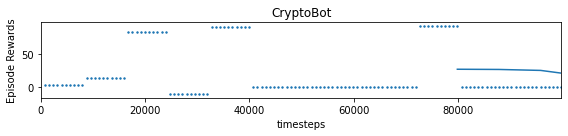

In [113]:
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy

test_env_dir = './logs/test_env/'
# Helper from the library
results_plotter.plot_results([test_env_dir], 1e5, results_plotter.X_TIMESTEPS, "CryptoBot")

In [114]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

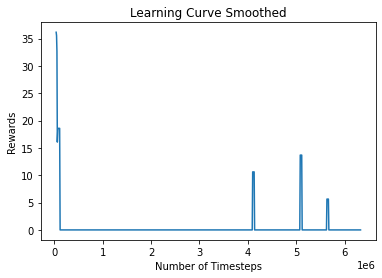

In [115]:
plot_results('./logs/test_env/')

In [116]:
model = RecurrentPPO.load('./logs/best_model.zip')


Average profit in ten runs: 0.08878592515915137


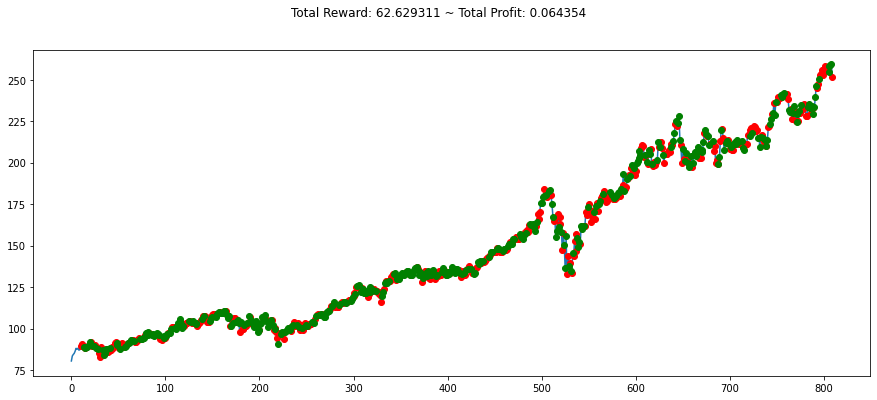

In [117]:
avg_profit = []
for i in range(10):
    test_env = MyStocksEnv(df=X, window_size=10, frame_bound=(8000, 8800))
    obs = test_env.reset()
    while True:
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = test_env.step(action)
        if done:
            avg_profit.append(info["total_profit"])
            #print("info", info)
            break

print("\nAverage profit in ten runs:", np.mean(avg_profit))
plt.figure(figsize=(15,6))
plt.cla()
test_env.render_all()
plt.show()